# TODO: Create framework for assessing quality of candidate generation.

In [72]:
import sys
sys.path.append('../src/')
pathToLUNA = '/scr/nodules/luna16/debug/'
pathToGoodFile = '/scr/nodules/luna16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd'
pathToErrorFile = '/scr/nodules/luna16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.mhd'
opts = None

import luna
import tan
import segutil as util
import matplotlib.pyplot as plt
import copy

In [85]:
import pandas as pd

In [73]:
sys.path.append('/home/g/Desktop/git/nodules/keras/')
sys.path.append('/home/g/Desktop/git/nodules/tf/')

import init
import kerasUtil as ku

import math
import scipy
import skimage.feature
import scipy.ndimage
import scipy.misc as scipy_misc
import scipy.ndimage.morphology as morphology
import numpy as np

from skimage import measure
from skimage import feature

In [3]:
image, imageName = luna.loadItk(pathToGoodFile, opts)
segmentation = util.segmentLung(image)
mask = luna.applyMask(image, segmentation)
imageCopy = copy.deepcopy(image)
minimum = np.min(image)
image[mask==0] = 0#minimum

SEGMENTING LUNG VOLUME ..


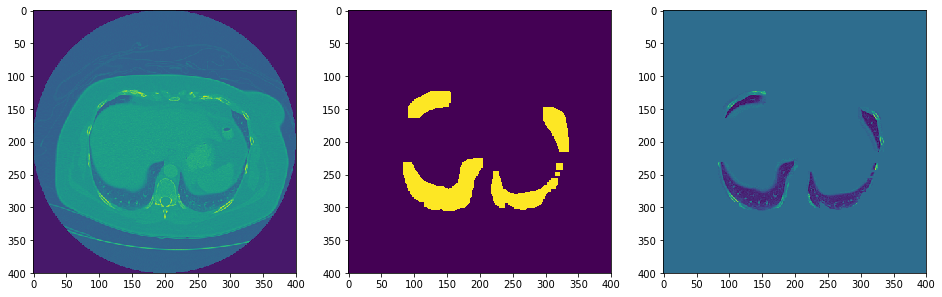

In [4]:
plt.figure(figsize=(16,16))
plt.subplot(133)
plt.imshow(image[int(1*image.shape[0]/4),:,:])
plt.subplot(131)
plt.imshow(imageCopy[int(1*imageCopy.shape[0]/4),:,:])
plt.subplot(132)
plt.imshow(mask[int(1*mask.shape[0]/4),:,:])
plt.show()

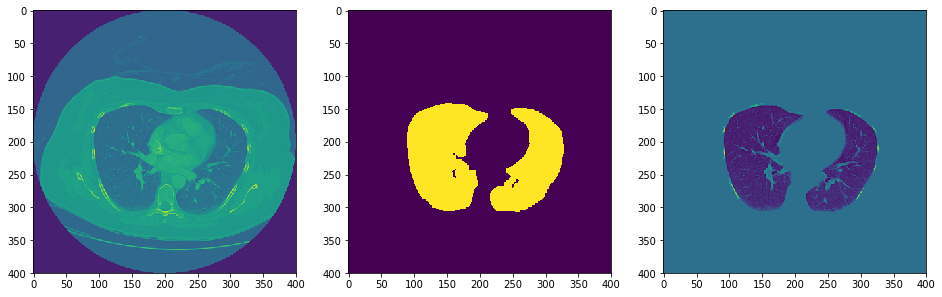

In [5]:
plt.figure(figsize=(16, 16))
plt.subplot(133)
plt.imshow(image[int(2*image.shape[0]/4),:,:])
plt.subplot(131)
plt.imshow(imageCopy[int(2*imageCopy.shape[0]/4),:,:])
plt.subplot(132)
plt.imshow(mask[int(2*mask.shape[0]/4),:,:])
plt.show()

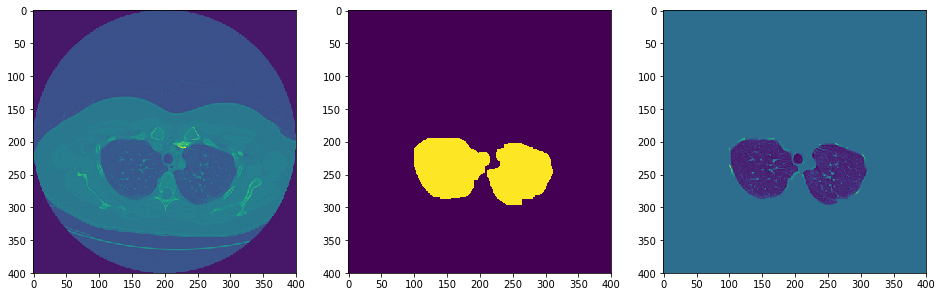

In [6]:
plt.figure(figsize=(16, 16))
plt.subplot(133)
plt.imshow(image[int(3*image.shape[0]/4),:,:])
plt.subplot(131)
plt.imshow(imageCopy[int(3*imageCopy.shape[0]/4),:,:])
plt.subplot(132)
plt.imshow(mask[int(3*mask.shape[0]/4),:,:])
plt.show()

In [7]:
D1 = 4.
D2 = 16.
no = 6
def getScales(opts,D1=4.,D2=16.,no=6):
  d0, d1, no = D1, D2, no
  sigma = []
  sigma.append(d0/4.)
  for i in range(1, no):
    val = ((d1/d0)**(1./(no-1.)))**i*sigma[0]
    sigma.append(val)
  print sigma
  return sigma

In [8]:
def multiscaleHessian2d(image, opts=None):
  scales = getScales(opts)
  cands = []
  for Sigma in scales:
    img = np.zeros(image.shape)
    hess = np.zeros((2,2)+image.shape)
    sig = np.zeros(image.shape)
    for i in range(image.shape[0]):
      img[i,:,:] = scipy.ndimage.filters.gaussian_filter(image[i,:,:],sigma=Sigma,order=0) 
      hess[:,:,i,:,:] = Hessian(img[i,:,:])
    cands.append(hess)
  return cands

In [9]:
def Hessian(L):
  hessian = np.zeros((L.ndim,L.ndim)+L.shape,dtype=L.dtype)
  dL = np.gradient(L)
  for i, d1 in enumerate(dL):
    d2L = np.gradient(d1)
    for j, d2 in enumerate(d2L):
      hessian[i,j] = d2
  return hessian

In [28]:
THRESH = 1.
def filterHessian(hessians, opts=None):
  hess = hessians[0]
  scales = getScales(opts)
  cands = np.zeros((hess.shape[2],hess.shape[3],hess.shape[4]))
  candidates = np.zeros((hess.shape[2],hess.shape[3],hess.shape[4]))
  lambdas = np.zeros((hess.shape[2],hess.shape[3],hess.shape[4]))
  for h in range(len(hessians)):
    hessian = hessians[h]
    for i in range(hess.shape[2]):
      for j in range(hess.shape[3]):
        for k in range(hess.shape[4]):
          lambdas = np.linalg.eigvals(hessian[:,:,i,j,k])
          l1 = lambdas[0]
          l2 = lambdas[1]
          if abs(l2) > abs(l1):
            tmp = l1
            l1 = l2
            l2 = tmp
          if l1 < 0 and l2 < 0:
            response = (l2*l2)/abs(l1)
            if response > candidates[i,j,k] and response > THRESH:
              candidates[i,j,k] = 1
  return candidates

These two functions crop the ROI to speed up computation.

In [11]:
def findROI(image):
  sums = 0
  zmin = 0
  zmax = image.shape[0] - 1
  while sums == 0:
    sumMax = np.sum(image[zmax,:,:])
    sumMin = np.sum(image[zmin,:,:])
    #print sumMax
    #print sumMin
    if sumMax == 0:
      zmax -= 1
    if sumMin == 0:
      zmin += 1
    sums = sumMax*sumMin
    
  sums = 0
  xmin = 0
  xmax = image.shape[1] - 1
  while sums == 0:
    sumMax = np.sum(image[:,xmax,:])
    sumMin = np.sum(image[:,xmin,:])
    if sumMax == 0:
      xmax -= 1
    if sumMin == 0:
      xmin += 1
    sums = sumMax*sumMin
    
  sums = 0
  ymin = 0
  ymax = image.shape[2] - 1
  while sums == 0:
    sumMax = np.sum(image[:,:,ymax])
    sumMin = np.sum(image[:,:,ymin])
    if sumMax == 0:
      ymax -= 1
    if sumMin == 0:
      ymin += 1
    sums = sumMax*sumMin
    
  return zmin,zmax,xmin,xmax,ymin,ymax

In [12]:
def crop(image):
  zmin,zmax,xmin,xmax,ymin,ymax = findROI(image)
  croppedImage = image[zmin:zmax,xmin:xmax,ymin:ymax]
  return croppedImage

271
38
313
120
337
80


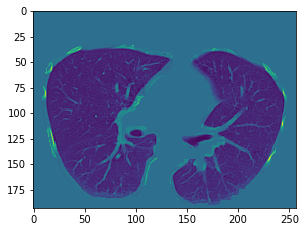

In [13]:
roi = crop(image)
plt.figure(figsize=(16,16))
plt.subplot(133)
plt.imshow(roi[int(2*roi.shape[0]/4),:,:])
plt.show()
plt.clf()

In [14]:
print image.shape[0]*image.shape[1]*image.shape[2]
print roi.shape[0]*roi.shape[1]*roi.shape[2]

43520000
11557033


In [44]:
scales = getScales(opts)
eigenvalues = []
for Sigma in scales:
  lambda1 = np.zeros(roi.shape)
  lambda2 = np.zeros(roi.shape)
  for i in range(roi.shape[0]):
    hxx, hxy, hyy = feature.hessian_matrix(roi[i,:,:],sigma=Sigma)
    lambda1[i,:,:], lambda2[i,:,:] = feature.hessian_matrix_eigvals(hxx,hxy,hyy)
  eigenvalues.append((lambda1,lambda2))

[1.0, 1.3195079107728942, 1.741101126592248, 2.2973967099940698, 3.0314331330207955, 3.999999999999999]


In [45]:
THRESH = 0.0
candidates = np.zeros(roi.shape)
for lambdas in eigenvalues:
  lambda1, lambda2 = lambdas
  for i in range(roi.shape[0]):
    for j in range(roi.shape[1]):
      for k in range(roi.shape[2]):
        l1 = lambda1[i,j,k]
        l2 = lambda2[i,j,k]
        if l1 < 0 and l2 < 0:
          if l1 > l2:
            response = (l1*l1)/abs(l2)
          else:
            response = (l2*l2)/abs(l1)
          if response > candidates[i,j,k] and response > THRESH:
            candidates[i,j,k] = 1

In [46]:
print np.sum(candidates)

8674302.0


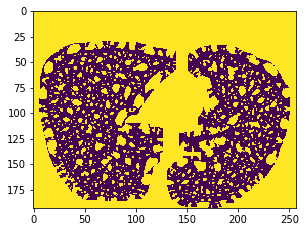

In [47]:
plt.figure(figsize=(16,16))
plt.subplot(133)
plt.imshow(candidates[int(2*candidates.shape[0]/4),:,:])
plt.show()
plt.clf()

In [29]:
roi = roi
cands = multiscaleHessian2d(roi)
newCands = filterHessian(cands)

[1.0, 1.3195079107728942, 1.741101126592248, 2.2973967099940698, 3.0314331330207955, 3.999999999999999]
[1.0, 1.3195079107728942, 1.741101126592248, 2.2973967099940698, 3.0314331330207955, 3.999999999999999]


In [50]:
VOLUME_THRESH_MIN = 15
VOLUME_THRESH_MAX = 20000

labels = np.zeros(newCands.shape)
labels = measure.label(newCands,connectivity=1)
cands = np.zeros(newCands.shape)
mx = np.max(labels)
for i in range(1,int(mx)):
  count = np.sum(newCands[labels == i])
  #print str(i) + ' ' + str(count)
  if count > VOLUME_THRESH and count < VOLUME_THRESH_MAX:
    cands[labels == i] = i
  #print str(i) + ' ' + str(np.sum(cands[labels == i])/i)
#print cands
moreCands = np.zeros(cands.shape)
moreCands[cands > 0] = 1

In [55]:
labels = np.zeros(candidates.shape)
labels = measure.label(candidates,connectivity=1)
cands = np.zeros(candidates.shape)
mx = np.max(labels)
for i in range(1,int(mx)):
  count = np.sum(candidates[labels == i])
  #print str(i) + ' ' + str(count)
  if count > VOLUME_THRESH and count < VOLUME_THRESH_MAX:
    cands[labels == i] = i
  #print str(i) + ' ' + str(np.sum(cands[labels == i])/i)
#print cands
moreCandsB = np.zeros(cands.shape)
moreCandsB[cands > 0] = 1

In [74]:
cp = copy.deepcopy(roi)
cp[moreCands == 1] = 1000

In [75]:
moreCandsC = cp

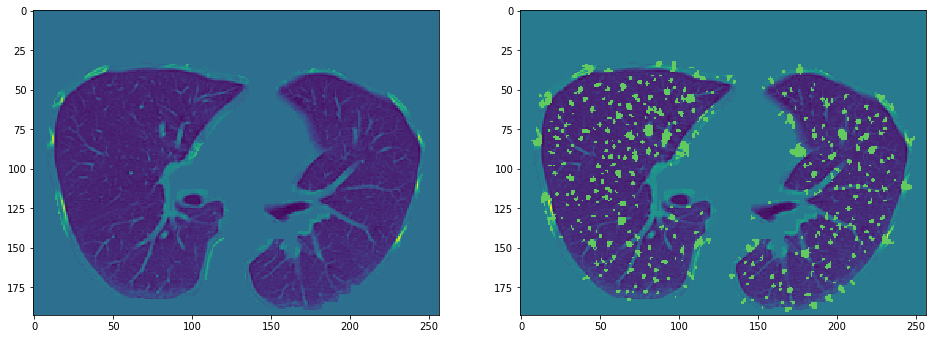

In [76]:
plt.figure(figsize=(16,16))
#plt.subplot(323)
#plt.imshow(moreCands[int(2*moreCands.shape[0]/4)-1,:,:])
#plt.imshow(newCands[int(2*newCands.shape[0]/4)-1,:,:])
plt.subplot(221)
plt.imshow(roi[int(2*roi.shape[0]/4),:,:])
plt.subplot(222)
#plt.imshow(candidates[int(2*candidates.shape[0]/4),:,:])
plt.imshow(moreCandsC[int(2*moreCandsC.shape[0]/4),:,:])
plt.show()
plt.clf()

In [82]:
cp2 = copy.deepcopy(roi)
cp2[newCands == 1] = 1000
newCandsB = cp2

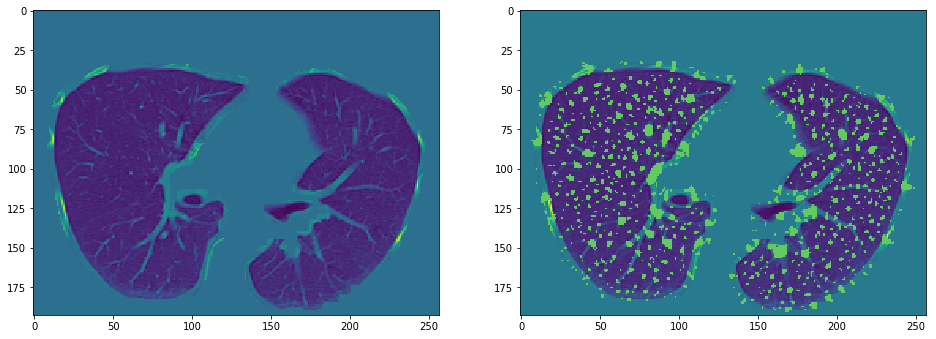

In [83]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(roi[int(2*roi.shape[0]/4),:,:])
plt.subplot(222)
plt.imshow(newCandsB[int(2*newCandsB.shape[0]/4),:,:])
plt.show()
plt.clf()

In [87]:
candPath = '/home/g/Desktop/git/nodules/resources/candidates.csv'
fcand = pd.read_csv(candPath)

In [92]:
currentImage = fcand[fcand['seriesuid'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112']
currentImage = currentImage[currentImage['class'] == 1]

In [93]:
print currentImage

                                                seriesuid     coordX  \
430985  1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499... -63.657959   

          coordY     coordZ  class  
430985 -5.124949 -84.133906      1  
